# 08. PyTorch Paper Replicating

The goal of machine learning researc paper replicating is :
turn a ML paper into usable code.

In this notebook,we're going to be replicating the vision Transformer(viT) architecture/paper with PyTorch.

## 0. Get setup

Import required Libraries

In [1]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.14.1+cu116


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3546, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 3546 (delta 69), reused 156 (delta 60), pack-reused 3378
Receiving objects: 100% (3546/3546), 641.46 MiB | 23.93 MiB/s, done.
Resolving deltas: 100% (2025/2025), done.
Updating files: 100% (236/236), done.


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

The whole goal of what we're trying to do to is to replicating the ViT architecture for our FoodVision Mini problem.

To do that,we need some data.

Namely,the pizza steak and sushi we've been using so far.

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

### 2.1 Prepare transforms for images

In [6]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# Create image size
IMG_SIZE = 224 # comes from Table 3 of the vit paper

# Create transform pipeline
manual_transforms = transforms.Compose([
                  transforms.Resize(size=(IMG_SIZE,IMG_SIZE)),
                  transforms.ToTensor()
                  ])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


### 2.2 Turn images into DataLoader's

In [7]:
# Create a batch size 32
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader,test_dataloader,class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader),len(test_dataloader),class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

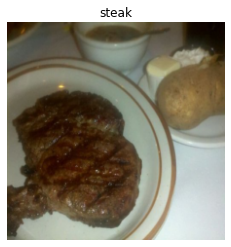

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating the ViT paper: an overview

So in order to make it more understandable, we can break it down into smaller pieces :

* **Input** - What goes into the model?(in our case,image tensors)

* **Outputs** - Whats comes out of the model/layer/block?(In our case, we want the model to ouput image classification labels)

* **Layers** - Take an Input,manipulates it with a function(for example could be self-attention).

* **Blocks**- A collection of layers.

* **Model**- A collection of block.

### 3.1 Inputs and outputs, layers and blocks

* Figure 1: Visual overview of the architecture

* Four equation: math equation which define the function of each layer/block

* Table 1/3: Different hyperparameter for the architecture/training.

* Text description(especially section 3.1)

### Figure 1

<img src = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-figure-1-architecture-overview.png" width = 600 alt = "figure 1 from vision transformer paper"/>

* Embedding = learnable representation (start with random numbers and improve over time)

### Four equation

<img src = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-four-equations.png" width = 600 alt = "four equations from vision transformer paper"/>

Section 3.1 describe the various equations  :

**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

In pseudocode:
```python
x_input = [class_token,image_patch_1,image_patch_2,.....,image_patch_N] + [class_token_pos,image_patch_1_pos,image_patch_2_pos,.....,image_patch_N_pos]
```

**Equation 2&3 :**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudocode:
```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

**Equation 4 :**
Similar to BERT's [class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = multilayer perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time

In pseudocode:

```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block))
```


### Table 1

<img src = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-table-1.png" width = 600 alt = "Table1 from vision transformer paper"/>

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture

* ViT-B/16 = ViT-Base with image patch size 16x16
Layers - the number of transformer encoder layers

* Hidden size $D$ - the embedding size throughout the architecture

* MLP size - the number of hidden units/neurons in the MLP

* Heads - the number of multi-head self-attention

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

As in, if we can represent our data in a good, learnable way (as embeddings are learnable representations), chances are, a learning algorithm will be able to perform well on them.

With that being said, let's start by creating the class, position and patch embeddings for the ViT architecture.

We'll start with the patch embedding.

This means we'll be turning our input images in a sequence of patches and then **embedding**(embedding is a learnable representation of some form and is often a vector) those patches.

The term learnable is important because this means the numerical representation of an input image (that the model sees) can be improved over time.

We'll begin by following the opening paragraph of section 3.1 of the ViT paper (bold mine):


>**Equation 1:**
  An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

Let's break down the text above.

* $D$
 is the size of the **patch embeddings**, different values for $D$ for various sized ViT models can be found in Table 1.

* The image starts as 2D with size $H × W × C$
  
  * $(H,W)$is the resolution of the original image (height, width).
  * C is the number of channels.

* The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^2 \cdot C\right)}$

 * $(P,P)$ is the resolution of each image patch (patch size).
 * $N=H W / P^2$ is the resulting number of patches, which also serves as the input sequence length for the Transformer.

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-annotated.png)






In [10]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height*width)/patch_size**2)
number_of_patches

196

In [11]:
# Input shape
embedding_layer_input_shape = (height,width,color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches,patch_size**2 * color_channels)

print(f"Input shape : {embedding_layer_input_shape}")
print(f"Output shape : {embedding_layer_output_shape}")

Input shape : (224, 224, 3)
Output shape : (196, 768)


### 4.2 Turning a single image into patches

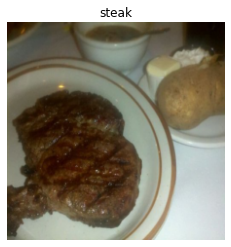

In [12]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

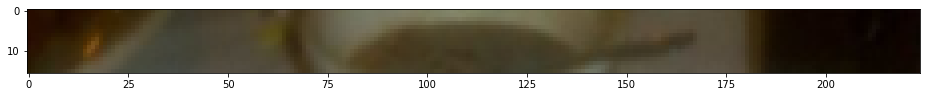

In [13]:
# Get the top row of the image
image_permuted = image.permute(1,2,0) # converted image to color channels last (H,W,C)

# Index to plot the top row of pixel
patch_size = 16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size,:,:])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


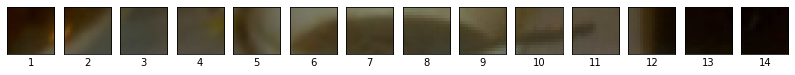

In [14]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1, 
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


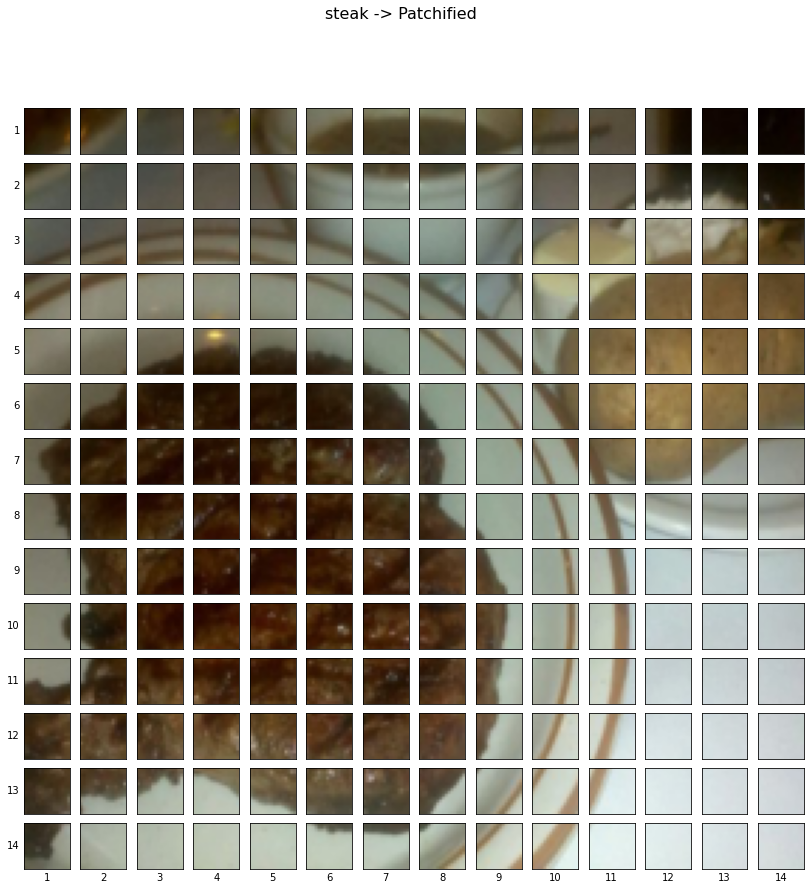

In [15]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size, 
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
        
        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height 
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels
        
        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### 4.3 Creating image patches and turning into patch embeddings

Perhaps we could create the image patches embeddings in a single step using `torch.nn.Conv2d()` and setting the kernal size and stride parameters to `patch_size`.

In [16]:
# Create conv2d layer to turn image into patches of learnable feature maps(embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameter from the ViT paper
conv2d = nn.Conv2d(in_channels=3,# for color image
                   out_channels=768, # D size from Table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

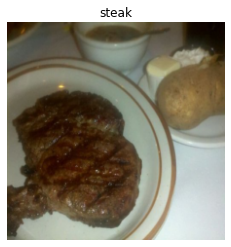

In [17]:
# View single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [18]:
# Pass the image through the convolutional layer 
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now we've passed a single image to our `conv2d` layer.it's shape is:
```python
torch.size([1,768,14,14]) # [batch_size,embedding_dim,feature_map_height,feature_map_width]
```

Showing random convolutional feature maps from indexes: [379, 512, 528, 680, 614]


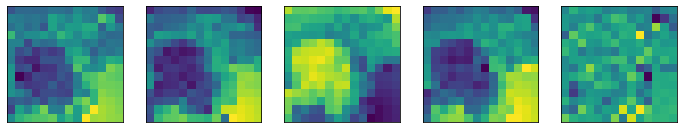

In [19]:
# plot random convolution feature maps(embeddings)
import random
random_indexes = random.sample(range(0,768),k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")


# Create plot
fig,axs = plt.subplots(nrows=1,ncols=5,figsize=(12,12))

#plot random image feature maps
for i,idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:,idx,:,:] # Index on the output tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # Remove batch dimension,and remove from grade tracking/switch to numpy for matplotlib
  axs[i].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[])


### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

Right now we've a serie of convolution feature maps (patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the input criteria of the ViT Transformer Encoder.

In [20]:
print(f"{image_out_of_conv.shape} -> [batch_size,embedding_dim,feature_map_height,feature_map_width]")

torch.Size([1, 768, 14, 14]) -> [batch_size,embedding_dim,feature_map_height,feature_map_width]


Want : [batch_size,number_of_patches,embedding_dim]

In [21]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Put Everything together

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


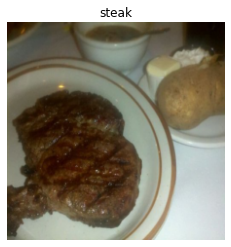

In [22]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [23]:
# Rearrange ouput of flattend layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0,2,1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> [batch_size,number_of_patches,embedding_dimension]")

torch.Size([1, 196, 768]) -> [batch_size,number_of_patches,embedding_dimension]


(-0.5, 195.5, 0.5, -0.5)

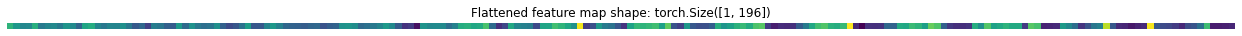

In [24]:
# Get a single flattened feature map
single_flattend_feature_map = image_out_of_conv_flattened_permuted[:,:,0]

# Plot the flattened feature map visually
plt.figure(figsize=(22,22))
plt.imshow(single_flattend_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattend_feature_map.shape}")
plt.axis(False)

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

We want this module to do a few things:

1. Create a class called `PatchEmbedding` that inherits from `nn.Module`

2. Initialize with appropiate hyperparameters,such as channels,embedding dimension,patch size.

3. Create a layer to turn an image into embeddings patches using `nn.Conv2d()`.

4. Create a layer to flatten the feature maps of the output of the layer in 3.

5. Define a `forword()` that defines the forward computation(e.g. pass through layer from 3 and 4).

6. Make sure the output shape of the layers reflect the required output shape of the patch embedding.

In [25]:
# 1. Create a class called PatchEmbedding
class PatchEmbedding(nn.Module):

  # 2. Initialize the layer with appropriate hyperparameters
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768): # from table 1 base

    super().__init__()

    self.patch_size = patch_size

    # 3. create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)
    
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)
  
  # 5. Define a forward method to define the forward computation steps
  def forward(self,x):
    # create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    # Perform the forword pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    # 6. Make the returned sequence embedding dimension are in the right order [batch_size,number_of_patches,embedding_dimension]
    return x_flattened.permute(0,2,1)

In [26]:
torch.manual_seed(128)

# Craete an instace of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension 
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [27]:
rand_image_tensor = torch.randn(1,3,224,224)
rand_image_tensor_bed = torch.rand(1,3,250,250)
# patchify(rand_image_tensor_bed)

### 4.6 Creating the class token embedding

Want to: prepend a learnable class token to the start of the patch embedding.

In [28]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size,embedding_dimension

(1, 768)

In [29]:
# Create a class token embedding as a learnable parameter that shares the same size as the embedding dimension(D)
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dimension),requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [30]:
x = torch.randn(2, 3)
print(f"X: {x}")
y = torch.ones(2,3)
print(f"\nY: {y}\n")

print(torch.cat((y, x), 1))
print("\n")
print(torch.cat((y, x), 0))

X: tensor([[ 0.4120,  0.4668, -2.0602],
        [ 0.0145,  0.3789, -0.7941]])

Y: tensor([[1., 1., 1.],
        [1., 1., 1.]])

tensor([[ 1.0000,  1.0000,  1.0000,  0.4120,  0.4668, -2.0602],
        [ 1.0000,  1.0000,  1.0000,  0.0145,  0.3789, -0.7941]])


tensor([[ 1.0000,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000],
        [ 0.4120,  0.4668, -2.0602],
        [ 0.0145,  0.3789, -0.7941]])


In [31]:
# add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token,patch_embedded_image),
                                                      dim=1) # Number_of_patches dimension


print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embedding with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} \
      ->[batch_size,class_token + number_of_patches,embedding_dim] ")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.0970, -0.0897, -0.0942,  ..., -0.1423,  0.0917, -0.0764],
         [ 0.1549, -0.1204, -0.1038,  ..., -0.2739,  0.1482, -0.1553],
         ...,
         [ 0.7639, -0.2245, -0.5377,  ..., -0.8481,  0.2624, -0.9272],
         [ 0.7453, -0.2227, -0.5198,  ..., -0.8154,  0.2593, -0.8979],
         [ 0.7107, -0.2088, -0.4997,  ..., -0.7917,  0.2539, -0.8570]]],
       grad_fn=<CatBackward0>)
Sequence of patch embedding with class token prepended shape: torch.Size([1, 197, 768])       ->[batch_size,class_token + number_of_patches,embedding_dim] 


### 4.7 Creating the position embedding

Want to: create a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings.

In [32]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding,patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.0970, -0.0897, -0.0942,  ..., -0.1423,  0.0917, -0.0764],
          [ 0.1549, -0.1204, -0.1038,  ..., -0.2739,  0.1482, -0.1553],
          ...,
          [ 0.7639, -0.2245, -0.5377,  ..., -0.8481,  0.2624, -0.9272],
          [ 0.7453, -0.2227, -0.5198,  ..., -0.8154,  0.2593, -0.8979],
          [ 0.7107, -0.2088, -0.4997,  ..., -0.7917,  0.2539, -0.8570]]],
        grad_fn=<CatBackward0>), torch.Size([1, 197, 768]))

In [33]:
# Calculate N(number_of_patches)
number_of_patches = int((height*width)/patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,number_of_patches+1,embedding_dimension),
                                  requires_grad=True)

position_embedding,position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [34]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding

patch_and_position_embedding,patch_and_position_embedding.shape

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [1.0970, 0.9103, 0.9058,  ..., 0.8577, 1.0917, 0.9236],
          [1.1549, 0.8796, 0.8962,  ..., 0.7261, 1.1482, 0.8447],
          ...,
          [1.7639, 0.7755, 0.4623,  ..., 0.1519, 1.2624, 0.0728],
          [1.7453, 0.7773, 0.4802,  ..., 0.1846, 1.2593, 0.1021],
          [1.7107, 0.7912, 0.5003,  ..., 0.2083, 1.2539, 0.1430]]],
        grad_fn=<AddBackward0>), torch.Size([1, 197, 768]))

### 4.8 Putting it all together: from image to embedding

We've written code to turn an image into a flattened sequence of patch embeddings.

Now let's it all one cell.

In [35]:
# Set seed
torch.manual_seed(128)
torch.cuda.manual_seed(128)

# 1. Set the patch size
patch_size = 16

# 2. Print shapes of the original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height,width = image.shape[1],image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dimension),requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token,patch_embedding),dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create pasition embedding
number_of_patches = int((height*width)/patch_size**2)
position_embedding = nn.Parameter(torch.ones(1,number_of_patches+1,embedding_dimension),
                                  requires_grad=True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Equation 2: Multihead Self-Attention (MSA block)

* **Multihead self-attention**: which part of a sequence should pay the most attention to itself?

  * In ou case,we have series of embedded image patches, which patch significantly relates to another patch.
  * We want our neural network(ViT) learn this relationship/representation

* **LayerNorm**: Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.

    * Normalization: make everything have the same mean and standerd deviation.
    * In Pytorch - https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html normalizes values over **D** dimension, in our case, the **D** dimension is the embedding dimension.
      * When we normalize along the embedding dimension.it's like making all of the stairs in a staircase the same size.

In [36]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """Create a multi-head self-attention block(MSA block for short)"""

  def __init__(self,
               embedding_dim:int=768, # Hidden size D
               num_heads:int=12, # Heads from Table 1 for ViT-Base
               attn_dropout:int=0):
    
    super().__init__()

    # create the norm layer(LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create multihead attention (MSA) layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True) # is the batch first? (batch,seq,feature) -> (batch,number_of_patches,embedding_dimension)


  def forward(self,x):
    x = self.layer_norm(x)
    attn_output,_ = self.multihead_attn(query=x,
                                        key=x,
                                        value = x,
                                        need_weights=False)
    
    return attn_output

In [37]:
# Create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)

# Pass the patch and position image embedding sequence through MSA block
patch_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patch_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [38]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.0970, 0.9103, 0.9058,  ..., 0.8577, 1.0917, 0.9236],
         [1.1549, 0.8796, 0.8962,  ..., 0.7261, 1.1482, 0.8447],
         ...,
         [1.7639, 0.7755, 0.4623,  ..., 0.1519, 1.2624, 0.0728],
         [1.7453, 0.7773, 0.4802,  ..., 0.1846, 1.2593, 0.1021],
         [1.7107, 0.7912, 0.5003,  ..., 0.2083, 1.2539, 0.1430]]],
       grad_fn=<AddBackward0>)

In [39]:
patch_image_through_msa_block

tensor([[[-0.5720,  0.4904, -0.0092,  ..., -0.3734,  0.8330,  0.3739],
         [-0.5727,  0.4820, -0.0135,  ..., -0.3752,  0.8273,  0.3561],
         [-0.5743,  0.4827, -0.0109,  ..., -0.3687,  0.8300,  0.3646],
         ...,
         [-0.5757,  0.4863, -0.0110,  ..., -0.3670,  0.8372,  0.3693],
         [-0.5757,  0.4863, -0.0111,  ..., -0.3670,  0.8372,  0.3693],
         [-0.5759,  0.4864, -0.0110,  ..., -0.3671,  0.8373,  0.3693]]],
       grad_fn=<TransposeBackward0>)

## 6. Equation 3: Multilayer Perceptron(MLP block)

* **MLP** - The MLP contains two layer with a GELU no-linearity 
  * MLP - a quite broad term for a block with a series of layer(s
, layers can be multiple even only one hidden layer.
  * Later can mean: fully-connected,dense,linear,feed-forword,all are often similar names for the same thing. In PyTorch, they're same thing. In PyTorch,they're often called `torch.nn.Linera()` and in Tensorflow they might be called `tf.keras.layers.Dense()`
  
In pseudocode:

```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```


In [40]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:int=0.1):
    super().__init__()

    # Create the norm layer(LN)
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )
  def forward(self,x):
    x= self.layer_norm(x)
    x = self.mlp(x)
    return x

In [41]:

# Create an instance of MLP bloclk
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=302,
                     dropout=0.1)

# Pass output the MSABlock through MLP block
patched_image_through_mlp_block = mlp_block(patch_image_through_msa_block)
print(f"Input shape of MLP block:{patch_image_through_msa_block.shape}")
print(f"ouput shape of MLP block:{patched_image_through_mlp_block.shape}")

Input shape of MLP block:torch.Size([1, 197, 768])
ouput shape of MLP block:torch.Size([1, 197, 768])


In [42]:
patch_image_through_msa_block

tensor([[[-0.5720,  0.4904, -0.0092,  ..., -0.3734,  0.8330,  0.3739],
         [-0.5727,  0.4820, -0.0135,  ..., -0.3752,  0.8273,  0.3561],
         [-0.5743,  0.4827, -0.0109,  ..., -0.3687,  0.8300,  0.3646],
         ...,
         [-0.5757,  0.4863, -0.0110,  ..., -0.3670,  0.8372,  0.3693],
         [-0.5757,  0.4863, -0.0111,  ..., -0.3670,  0.8372,  0.3693],
         [-0.5759,  0.4864, -0.0110,  ..., -0.3671,  0.8373,  0.3693]]],
       grad_fn=<TransposeBackward0>)

In [43]:
patched_image_through_mlp_block

tensor([[[-0.0499, -0.1496,  0.0000,  ...,  0.2946,  0.2939,  0.1175],
         [ 0.0703, -0.1206, -0.1385,  ...,  0.4267,  0.0783,  0.0249],
         [-0.0185, -0.0000,  0.0235,  ...,  0.4496,  0.0000, -0.0089],
         ...,
         [ 0.1579, -0.1360,  0.0926,  ...,  0.2982,  0.0465,  0.1398],
         [ 0.0391, -0.1230, -0.0102,  ...,  0.3897,  0.0000,  0.0392],
         [ 0.0066, -0.1080, -0.0664,  ...,  0.2207,  0.2191, -0.0442]]],
       grad_fn=<MulBackward0>)

## 7. Creating the Transformer Encoder

The Transformer Encoder is a combination of alternating blocks of MSA(equation 2) and MLP (equation 3).

And there are residual connection between each block.

* Encoder - Turn a sequence into learnable representation.

* Decoder - Go from learn representation back to some sort of sequence.

* Residual connection - Add a layer(s) input to its subsequent output,this enables the creation of deeper networks (prevent weight from getting too small)

```python
# Transformer encode
x_input = MSA_block -> [MSA_block_output+x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```

### 7.1 Create a custom Transformer Encoder block

In [44]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12, # from table 1
               mlp_size:int=3072, # from table 1
               mlp_dropout:int=0.1, # from table 3
               attn_dropout:int=0):
  
    super().__init__()

    # Create MSA block(equation 2)
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)
    
    # Create MLP block(equation 3)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)
    
  def forward(self,x):
    x = self.msa_block(x) + x # residual/skip connection for equation 2
    x = self.mlp_block(x) + x # residual/skip connection for equation 3
    return x

In [45]:
# create a instace of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.3 Create a transformer encoder layer with in-built PyTorch layers

So far we've created a transformer encoder by hand.

But because of how good the Transformer architecture is, PyTorch has implemented ready to use Transformer encoder layer: https://pytorch.org/docs/stable/nn.html#transformer-layers

We can create a Transformer Encoder with pure PyTorch layers:https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#transformerencoder

In [46]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Embedding size from table 1
                                                             nhead=12, # head from table 1
                                                             dim_feedforward=3072, # MLP size from table
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)


torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [47]:
# Get a summary using torchinfo.summary
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## 8. Putting it all together to create ViT


In [48]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__()

        # 3. Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1) 
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [49]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}") 
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [50]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

### 8.1 Getting a visual summary of our ViT model

In [51]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

## 9. Setting up training code for our ViT model

### 9.1 Creating an optimizer

The paper states it uses the Adam optimizer (section 4, Training & fine-tuning) with $B1$ 
 value of 0.9, $B2$
 of 0.999 (defaults) and a weight decay of 0.1.

Weight decay = Weight decay is a regularization technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function.

Regularization technique = prevents overfitting.

In [52]:
optimizer = torch.optim.Adam(vit.parameters(), 
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

### 9.2 Creating a loss function

The ViT paper doesn't actually mention what loss function they used.

So since it's a multi-class classification we'll use the `torch.nn.CrossEntropyLoss().`

In [53]:
loss_fn = torch.nn.CrossEntropyLoss()

### 9.3 Training our ViT Model

In [54]:
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.0699 | train_acc: 0.2656 | test_loss: 1.4997 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.4475 | train_acc: 0.3906 | test_loss: 1.7319 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.8352 | train_acc: 0.2422 | test_loss: 1.0174 | test_acc: 0.5417
Epoch: 4 | train_loss: 1.5982 | train_acc: 0.2812 | test_loss: 1.1624 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.3777 | train_acc: 0.2656 | test_loss: 1.0812 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1990 | train_acc: 0.2930 | test_loss: 1.2837 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.2968 | train_acc: 0.3086 | test_loss: 1.3126 | test_acc: 0.5417
Epoch: 8 | train_loss: 1.2763 | train_acc: 0.4648 | test_loss: 1.4642 | test_acc: 0.5417
Epoch: 9 | train_loss: 1.3809 | train_acc: 0.2891 | test_loss: 1.2043 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.1746 | train_acc: 0.4023 | test_loss: 1.1644 | test_acc: 0.5417


### 9.4 Plotting loss curves for our model

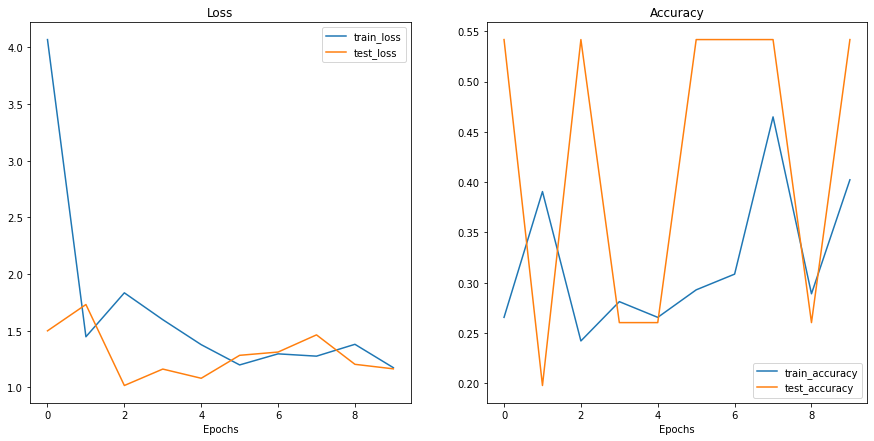

In [55]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 10. Using a pretrained ViT from torchvision.models

### 10.1 Why use a pretrained model?

* Sometimes data is limited
* Limited training resources
* Get better results faster (sometimes)...

In [56]:
# The following requires torch v0.12+ and torchvision 0.13+
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.14.1+cu116


In [57]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 10.2 Prepare a pretrained ViT for use with FoodVision Mini (turn it into a feature extractor)

In [58]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" = best available

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

# Update the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [59]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])
     

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 10.3 Preparing data for the pretrained ViT model

When using a pretrained model, you want to make sure your data is formatted in the same way that the model was trained on.

In [60]:
# Get automtic transforms from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [61]:
# Setup dataloaders
from going_modular.going_modular import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32) 

### 10.4 Train feature extractor ViT model

In [62]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
set_seeds() 
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7665 | train_acc: 0.7227 | test_loss: 0.5432 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.3428 | train_acc: 0.9453 | test_loss: 0.3263 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2064 | train_acc: 0.9531 | test_loss: 0.2707 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.1556 | train_acc: 0.9570 | test_loss: 0.2422 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.1246 | train_acc: 0.9727 | test_loss: 0.2279 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1216 | train_acc: 0.9766 | test_loss: 0.2129 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0938 | train_acc: 0.9766 | test_loss: 0.2352 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0797 | train_acc: 0.9844 | test_loss: 0.2281 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.1098 | train_acc: 0.9883 | test_loss: 0.2074 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0650 | train_acc: 0.9883 | test_loss: 0.1804 | test_acc: 0.9176


### 10.5 Plot the loss curves of our pretrained ViT feature extractor model

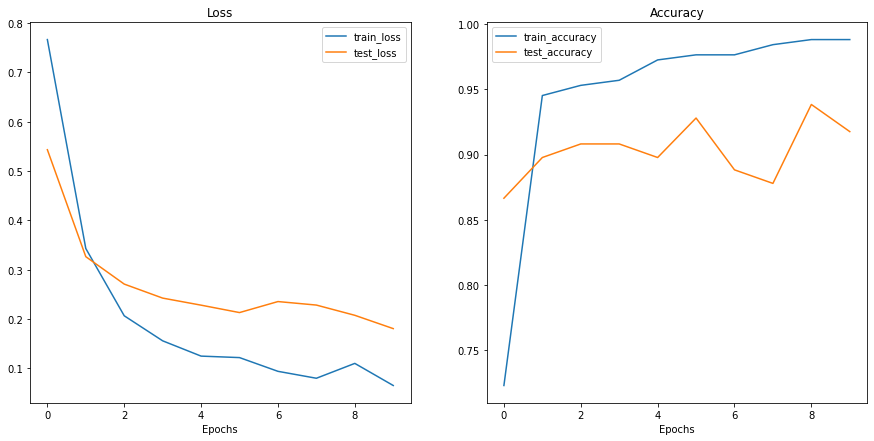

In [63]:

from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### 10.6 Save our best performing ViT model

In [64]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [65]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes 
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


## 11. Predicting on a custom image

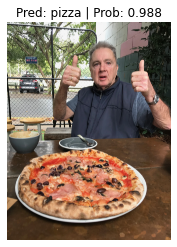

In [66]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)